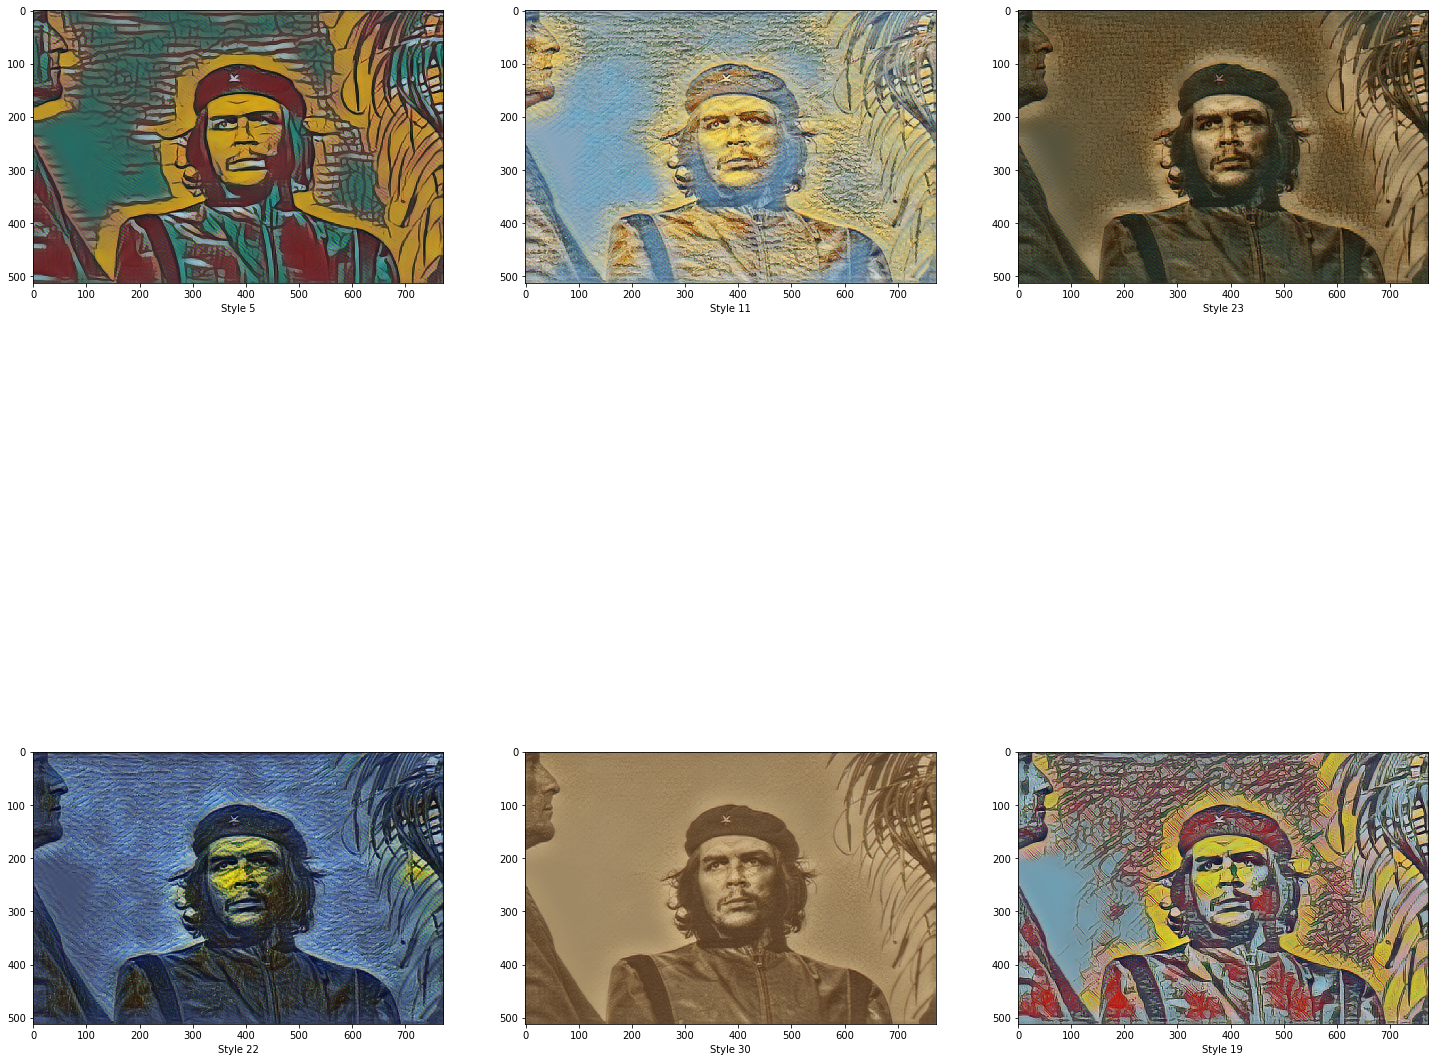

In [1]:
"""
A small Jupyter demo of the fast image stylization. To use, install jupyter and from this
directory run 'jupyter notebook'
"""
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import matplotlib.pyplot as plt
%matplotlib inline

import ast
import os
import sys
import random
import numpy as np
import tensorflow as tf
from six.moves.urllib.request import urlopen

import image_utils
import model

def DownloadCheckpointFiles(checkpoint_dir='checkpoints'):
    """Download checkpoint files if necessary."""
    url_prefix = 'http://download.magenta.tensorflow.org/models/' 
    checkpoints = ['multistyle-pastiche-generator-monet.ckpt', 'multistyle-pastiche-generator-varied.ckpt']
    for checkpoint in checkpoints:
        full_checkpoint = os.path.join(checkpoint_dir, checkpoint)
        if not os.path.exists(full_checkpoint):
            print('Downloading {}'.format(full_checkpoint))
            response = urlopen(url_prefix + checkpoint)
            data = response.read()
            with open(full_checkpoint, 'wb') as fh:
                fh.write(data)

# Select an image (any jpg or png).
input_image = './evaluation_images/guerrillero_heroico.jpg'

# Select a demo ('varied' or 'monet')
demo = 'varied'

# create 'checkpoints' directory if it doesn't exist
if not os.path.isdir('checkpoints'):
    os.makedirs('checkpoints')

DownloadCheckpointFiles()
image = np.expand_dims(image_utils.load_np_image(
          os.path.expanduser(input_image)), 0)
if demo == 'monet':
    checkpoint = 'checkpoints/multistyle-pastiche-generator-monet.ckpt'
    num_styles = 10  # Number of images in checkpoint file. Do not change.
elif demo == 'varied':
    checkpoint = 'checkpoints/multistyle-pastiche-generator-varied.ckpt'
    num_styles = 32  # Number of images in checkpoint file. Do not change.
    
# Styles from checkpoint file to render. They are done in batch, so the more 
# rendered, the longer it will take and the more memory will be used.
# These can be modified as you like. Here we randomly select six styles.
styles = list(range(num_styles))
random.shuffle(styles)
which_styles = styles[0:6]
num_rendered = len(which_styles)

with tf.Graph().as_default(), tf.Session() as sess:
    stylized_images = model.transform(
        tf.concat([image for _ in range(num_rendered)], 0),
        normalizer_params={
            'labels': tf.constant(which_styles),
            'num_categories': num_styles,
            'center': True,
            'scale': True})
    model_saver = tf.train.Saver(tf.global_variables())
    model_saver.restore(sess, checkpoint)
    stylized_images = stylized_images.eval()
    
# Plot the images.
counter = 0
num_cols = 3
f, _ = plt.subplots(num_rendered // num_cols, num_cols, figsize=(25, 25))
for counter, axis in enumerate(f.axes):
    axis.imshow(stylized_images[counter])
    axis.set_xlabel('Style %i' % which_styles[counter])
        